In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
from glob import glob
from tensorflow import keras
from keras.optimizers import SGD
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, jaccard_score

In [29]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [30]:
globals()['IMAGE_DIR'] = r"C:\Users\SamuelMcmurray\Documents\SchoolStuff\JU\DeepLearning\Project\deeplearning_project\images"
globals()['MASK_DIR'] = r"C:\Users\SamuelMcmurray\Documents\SchoolStuff\JU\DeepLearning\Project\deeplearning_project\masks"
globals()['IMAGE_SIZE'] = 128
globals()['BATCH_SIZE'] = 6
globals()['NUM_CLASSES'] = 21

train_images = sorted(glob(os.path.join(IMAGE_DIR, "images/*")))[:2328] #80
train_masks = sorted(glob(os.path.join(MASK_DIR, "masks/*")))[:2328] #80
val_images = sorted(glob(os.path.join(IMAGE_DIR, "images/*")))[2328:]   #20
val_masks = sorted(glob(os.path.join(MASK_DIR, "masks/*")))[2328:]  #20

In [31]:
all_dict = {
    'stuff': 'stuff',
    'indoor': 'stuff',
    'outdoor': 'stuff',
    'rawmaterial': 'indoor',
    'wall': 'indoor',
    'ceiling': 'indoor',
    'floor': 'indoor',
    'window': 'indoor',
    'furniture': 'indoor',
    'textile': 'indoor',
    'food': 'indoor',
    'building': 'outdoor',
    'structural': 'outdoor',
    'plant': 'outdoor',
    'sky': 'outdoor',
    'solid': 'outdoor',
    'ground': 'outdoor',
    'water': 'outdoor',
    'cardboard': 'rawmaterial',
    'paper': 'rawmaterial',
    'plastic': 'rawmaterial',
    'metal': 'rawmaterial',
    'wall-tile': 'wall',
    'wall-panel': 'wall',
    'wall-wood': 'wall',
    'wall-brick': 'wall',
    'wall-stone': 'wall',
    'wall-concrete': 'wall',
    'wall-other': 'wall',
    'ceiling-tile': 'ceiling',
    'ceiling-other': 'ceiling',
    'carpet': 'floor',
    'floor-tile': 'floor',
    'floor-wood': 'floor',
    'floor-marble': 'floor',
    'floor-stone': 'floor',
    'floor-other': 'floor',
    'window-blind': 'window',
    'window-other': 'window',
    'door': 'furniture',
    'desk': 'furniture',
    'table': 'furniture',
    'shelf': 'furniture',
    'cabinet': 'furniture',
    'cupboard': 'furniture',
    'mirror': 'furniture',
    'counter': 'furniture',
    'light': 'furniture',
    'stairs': 'furniture',
    'furniture-other': 'furniture',
    'rug': 'textile',
    'mat': 'textile',
    'towel': 'textile',
    'napkin': 'textile',
    'clothes': 'textile',
    'cloth': 'textile',
    'curtain': 'textile',
    'blanket': 'textile',
    'pillow': 'textile',
    'banner': 'textile',
    'textile-other': 'textile',
    'fruit': 'food',
    'salad': 'food',
    'vegetable': 'food',
    'food-other': 'food',
    'house': 'building',
    'skyscraper': 'building',
    'bridge': 'building',
    'tent': 'building',
    'roof': 'building',
    'building-other': 'building',
    'fence': 'structural',
    'cage': 'structural',
    'net': 'structural',
    'railing': 'structural',
    'structural-other': 'structural',
    'grass': 'plant',
    'tree': 'plant',
    'bush': 'plant',
    'leaves': 'plant',
    'flower': 'plant',
    'branch': 'plant',
    'moss': 'plant',
    'straw': 'plant',
    'plant-other': 'plant',
    'clouds': 'sky',
    'sky-other': 'sky',
    'wood': 'solid',
    'rock': 'solid',
    'stone': 'solid',
    'mountain': 'solid',
    'hill': 'solid',
    'solid-other': 'solid',
    'sand': 'ground',
    'snow': 'ground',
    'dirt': 'ground',
    'mud': 'ground',
    'gravel': 'ground',
    'road': 'ground',
    'pavement': 'ground',
    'railroad': 'ground',
    'platform': 'ground',
    'playingfield': 'ground',
    'ground-other': 'ground',
    'fog': 'water',
    'river': 'water',
    'sea': 'water',
    'waterdrops': 'water',
    'water-other': 'water',
    'things': 'things',
    'indoor': 'things',
    'outdoor': 'things',
    'person': 'outdoor',
    'vehicle': 'outdoor',
    'outdoor': 'outdoor',
    'animal': 'outdoor',
    'accessory': 'outdoor',
    'sports': 'outdoor',
    'kitchen': 'indoor',
    'food': 'indoor',
    'furniture': 'indoor',
    'electronic': 'indoor',
    'appliance': 'indoor',
    'indoor': 'indoor',
    'person': 'person',
    'bicycle': 'vehicle',
    'car': 'vehicle',
    'motorcycle': 'vehicle',
    'airplane': 'vehicle',
    'bus': 'vehicle',
    'train': 'vehicle',
    'truck': 'vehicle',
    'boat': 'vehicle',
    'traffic light': 'outdoor',
    'fire hydrant': 'outdoor',
    'street sign': 'outdoor',
    'stop sign': 'outdoor',
    'parking meter': 'outdoor',
    'bench': 'outdoor',
    'bird': 'animal',
    'cat': 'animal',
    'dog': 'animal',
    'horse': 'animal',
    'sheep': 'animal',
    'cow': 'animal',
    'elephant': 'animal',
    'bear': 'animal',
    'zebra': 'animal',
    'giraffe': 'animal',
    'hat': 'accessory',
    'backpack': 'accessory',
    'umbrella': 'accessory',
    'shoe': 'accessory',
    'eye glasses': 'accessory',
    'handbag': 'accessory',
    'tie': 'accessory',
    'suitcase': 'accessory',
    'frisbee': 'sports',
    'skis': 'sports',
    'snowboard': 'sports',
    'sports ball': 'sports',
    'kite': 'sports',
    'baseball bat': 'sports',
    'baseball glove': 'sports',
    'skateboard': 'sports',
    'surfboard': 'sports',
    'tennis racket': 'sports',
    'bottle': 'kitchen',
    'plate': 'kitchen',
    'wine glass': 'kitchen',
    'cup': 'kitchen',
    'fork': 'kitchen',
    'knife': 'kitchen',
    'spoon': 'kitchen',
    'bowl': 'kitchen',
    'banana': 'food',
    'apple': 'food',
    'sandwich': 'food',
    'orange': 'food',
    'broccoli': 'food',
    'carrot': 'food',
    'hot dog': 'food',
    'pizza': 'food',
    'donut': 'food',
    'cake': 'food',
    'chair': 'furniture',
    'couch': 'furniture',
    'potted plant': 'furniture',
    'bed': 'furniture',
    'mirror': 'furniture',
    'dining table': 'furniture',
    'window': 'furniture',
    'desk': 'furniture',
    'toilet': 'furniture',
    'door': 'furniture',
    'tv': 'electronic',
    'laptop': 'electronic',
    'mouse': 'electronic',
    'remote': 'electronic',
    'keyboard': 'electronic',
    'cell phone': 'electronic',
    'microwave': 'appliance',
    'oven': 'appliance',
    'toaster': 'appliance',
    'sink': 'appliance',
    'refrigerator': 'appliance',
    'blender': 'appliance',
    'book': 'indoor',
    'clock': 'indoor',
    'vase': 'indoor',
    'scissors': 'indoor',
    'teddy bear': 'indoor',
    'hair drier': 'indoor',
    'toothbrush': 'indoor',
    'hair brush': 'indoor',
}

In [32]:
label_color_map = [
    ['background', 0, 0, 0],  # background!
    ['boat', 128, 0, 0], # boat!
    ['bicycle', 0, 128, 0], # bicycle!
    ['bus', 128, 128, 0], # bus!
    ['aeroplane', 0, 0, 128], # aeroplaane!
    ['bottle', 128, 0, 128], # bottle!
    ['bird',0, 128, 128], # bus!
    ['car', 128, 128, 128], # car!
    ['cat', 0, 0, 64], # cat!
    ['cow', 0, 128, 64], # cow!
    ['horse', 128, 0, 192], # horse!
    ['motorbike',128, 128, 64], # motorbike!
    ['person', 128, 128, 192], # person !
    ['pottedplant', 0, 64, 0], # potted plant
    ['tv\monitor', 128, 64, 0], #tv!
    ['sofa', 0, 192, 0], # sofa!
    ['sheep', 0, 64, 128],# sheep !
    ['train', 0, 192, 128,], #train!
    ['chair',  0,   0, 192], #chair!
    ['dog', 128,   0,  64 ], #dog!
    ['diningtable', 0, 128, 192]
]

In [33]:
classes = []
color_map = []
for label_color in label_color_map:
    classes.append(label_color[0])
    color_map.append([label_color[1], label_color[2], label_color[3]])
print(classes)
print(color_map)
print(len(classes))

['background', 'boat', 'bicycle', 'bus', 'aeroplane', 'bottle', 'bird', 'car', 'cat', 'cow', 'horse', 'motorbike', 'person', 'pottedplant', 'tv\\monitor', 'sofa', 'sheep', 'train', 'chair', 'dog', 'diningtable']
[[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128], [0, 0, 64], [0, 128, 64], [128, 0, 192], [128, 128, 64], [128, 128, 192], [0, 64, 0], [128, 64, 0], [0, 192, 0], [0, 64, 128], [0, 192, 128], [0, 0, 192], [128, 0, 64], [0, 128, 192]]
21


In [34]:
def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = x.astype(np.float32)

    return x

In [35]:
def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))

    # path = r'C:\Users\SamuelMcmurray\Documents\SchoolStuff\JU\DeepLearning\Project\deeplearning_project\testmask'
    # save_image_path = os.path.join(path, "original.jpg")
    # cv2.imwrite(save_image_path, x)
    # np.set_printoptions(threshold=sys.maxsize)
    # print(x)
    output = []
    for i, color in enumerate(color_map):
        c_map = np.all(np.equal(x,color), axis=-1)
        # if True in c_map:
        #     print(classes[i])
        output.append(c_map)
        # save_image_path = os.path.join(path, f"{i}.png")
        # cv2.imwrite(save_image_path, c_map * 255)

    output = np.stack(output, axis=-1)
    output = output.astype(np.uint8)

    return output

In [36]:
def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y

    image, mask = tf.numpy_function(f, [x,y], [tf.float32, tf.uint8])
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    mask.set_shape([IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES])
    return image, mask

In [37]:
def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(2)
    return dataset

In [38]:
train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

In [39]:
print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(6, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(6, 128, 128, 21), dtype=tf.uint8, name=None))>
Val Dataset: <PrefetchDataset element_spec=(TensorSpec(shape=(6, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(6, 128, 128, 21), dtype=tf.uint8, name=None))>


In [40]:
def get_keys_as_list(dictionary):
    return list(map(lambda x: x[0], dictionary.items()))

In [41]:
def build_adjacency_matrix(connection_dict, directed=True):
    # Connection is from  row TO collumn.
    new_all = np.unique(get_keys_as_list(connection_dict)) # Assumption! See text above
    M = len(new_all)

    word2idx = {word:i for (i,word) in enumerate(new_all)}
    idx2word = {i:word for (i,word) in enumerate(new_all)}
    adj_m = np.zeros((M,M))
    for leaf in connection_dict.keys():
        parent = connection_dict[leaf]

        adj_m[word2idx[parent],word2idx[leaf]] = 1 # Adds connection from parent to child
        if not directed:
            adj_m[word2idx[leaf],word2idx[parent]] = 1 # Adds connection back from child to parent

    return  adj_m, word2idx, idx2word, new_all

In [42]:
num_epochs = 500

In [43]:
model = sm.Unet(
    'resnet101',
    encoder_weights='imagenet',
    classes=NUM_CLASSES,
    activation='softmax',
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

In [44]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="tb_callback_dir,", histogram_freq=1)
metrics=[
    'accuracy',
    keras.metrics.MeanIoU(num_classes=NUM_CLASSES, name="MeanIoU")
]
callbacks = [
    keras.callbacks.ModelCheckpoint("resnet101\\save_at_{epoch}.keras"),
    tensorboard_callback,
    keras.callbacks.EarlyStopping(patience=20)
]
model.compile(
    optimizer=SGD(learning_rate=2.5e-3),
    loss="categorical_crossentropy",
    metrics=metrics,
)

history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=callbacks
)
model.save("../models/resnet101.hdf5")

Epoch 1/500
388/388 [==============================] - 60s 139ms/step - loss: 1.4081 - accuracy: 0.7259 - MeanIoU: 0.4777 - val_loss: 1.8797 - val_accuracy: 0.7334 - val_MeanIoU: 0.4781
Epoch 2/500
388/388 [==============================] - 52s 133ms/step - loss: 1.1122 - accuracy: 0.7598 - MeanIoU: 0.4777 - val_loss: 1.3168 - val_accuracy: 0.7349 - val_MeanIoU: 0.4781
Epoch 3/500
388/388 [==============================] - 51s 131ms/step - loss: 1.0393 - accuracy: 0.7599 - MeanIoU: 0.4777 - val_loss: 1.0985 - val_accuracy: 0.7352 - val_MeanIoU: 0.4781
Epoch 4/500
388/388 [==============================] - 52s 133ms/step - loss: 0.9908 - accuracy: 0.7618 - MeanIoU: 0.4777 - val_loss: 1.0467 - val_accuracy: 0.7442 - val_MeanIoU: 0.4781
Epoch 5/500
388/388 [==============================] - 52s 135ms/step - loss: 0.9513 - accuracy: 0.7647 - MeanIoU: 0.4777 - val_loss: 1.0108 - val_accuracy: 0.7478 - val_MeanIoU: 0.4781
Epoch 6/500
388/388 [==============================] - 52s 135ms/step 

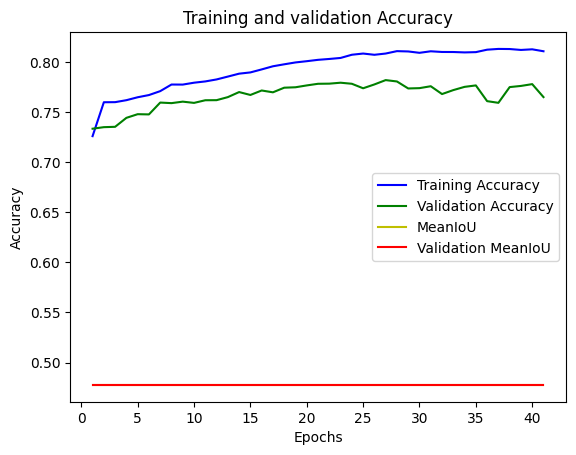

In [45]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
mean_iou = history.history["MeanIoU"]
val_mean_iou = history.history["val_MeanIoU"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.plot(epochs, mean_iou, 'y', label='MeanIoU')
plt.plot(epochs, mean_iou, 'r', label='Validation MeanIoU')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

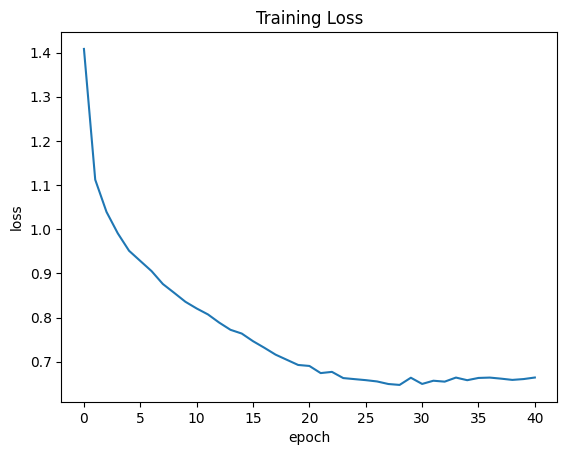

In [46]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

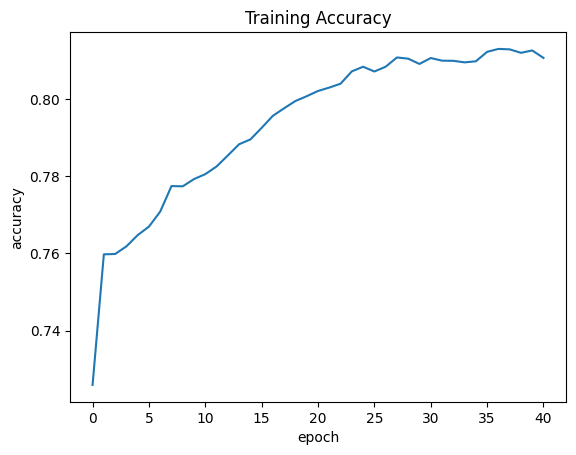

In [47]:
plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

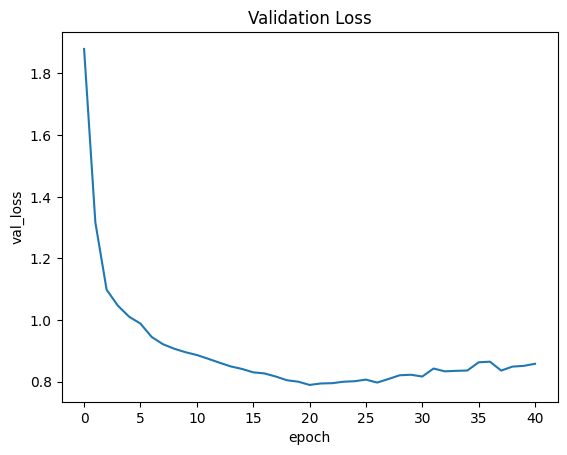

In [48]:
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

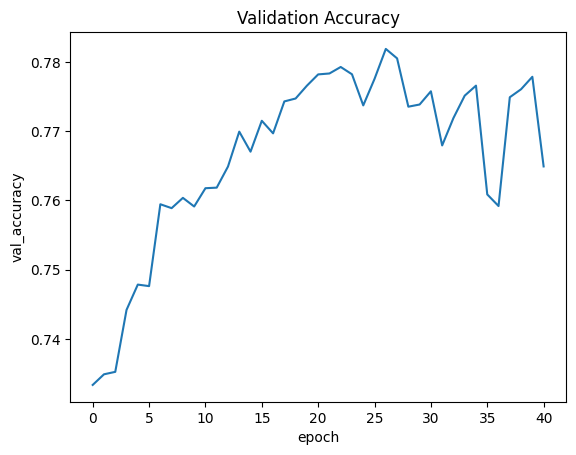

In [49]:
plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

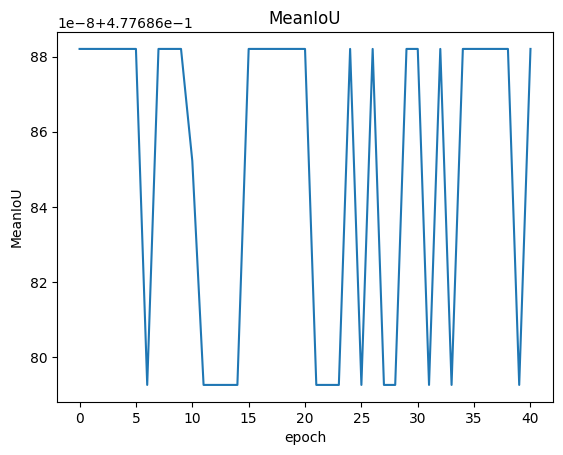

In [50]:
plt.plot(history.history["MeanIoU"])
plt.title("MeanIoU")
plt.ylabel("MeanIoU")
plt.xlabel("epoch")
plt.show()

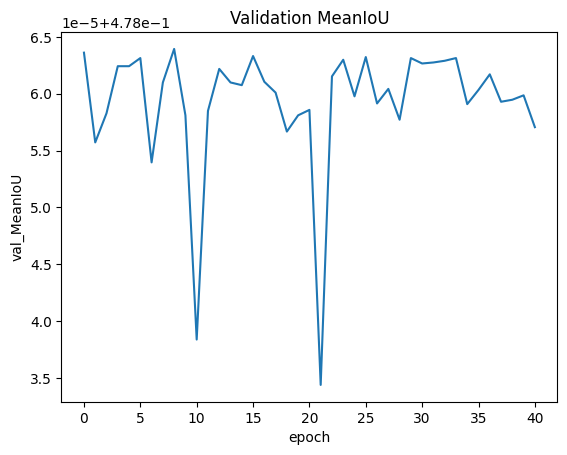

In [51]:
plt.plot(history.history["val_MeanIoU"])
plt.title("Validation MeanIoU")
plt.ylabel("val_MeanIoU")
plt.xlabel("epoch")
plt.show()

In [52]:
def grayscale_to_rgb(x_pred, classes, colormap):
    h,w, _ = x_pred.shape
    x_pred = x_pred.astype(np.int32)

    output=[]
    for i, pixel in enumerate(x_pred.flatten()):
        output.append(colormap[pixel])

    output = np.reshape(output, (h,w,3))
    return output

In [53]:
def save_image_pred(x_image, x_mask, prediction, path_save_image):
    h,w,_ = x_image.shape
    line = np.ones((h,w,3)) * 255

    prediction = np.expand_dims(prediction, axis=-1)
    prediction = grayscale_to_rgb(prediction, classes, color_map)

    cat_images = np.concatenate([x_image, line, x_mask, line, prediction])
    cv2.imwrite(path_save_image, cat_images)

In [54]:
# SCORE = []
# for x, y in tqdm(zip(val_images, val_masks), total=500):
#     name = x.split("/")[-1].split(".")[0]
#     image = cv2.imread(x, cv2.IMREAD_COLOR)
#     image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
#     image_x = image
#     image = image/255.0
#     image = np.expand_dims(image, axis=0)
#
#     mask = cv2.imread(y, cv2.IMREAD_COLOR)
#     mask = cv2.imread(y, cv2.IMREAD_COLOR)
#     mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
#     mask_x = mask
#     onehot_mask = []
#     for color in color_map:
#         cmap = np.all(np.equal(mask, color), axis=-1)
#         onehot_mask.append(cmap)
#     onehot_mask = np.stack(onehot_mask, axis=-1)
#     onehot_mask = np.argmax(onehot_mask, axis=-1)
#     onehot_mask = onehot_mask.astype(np.int32)
#
#     pred = model.predict(image, verbose=0)[0]
#     pred = np.argmax(pred, axis=-1)
#     pred = pred.astype(np.float32)
#
#     results_dir = r'C:\Users\SamuelMcmurray\Documents\SchoolStuff\JU\DeepLearning\Project\deeplearning_project\result\resnet'
#     print(results_dir)
#     save_path = os.path.join(results_dir,"{}.png".format(name))
#     print(save_path)
#     save_image_pred(image_x, mask_x, pred, save_path)
#
#     labels = [i for i in range(classes)]
#
#     f1_value = f1_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)
#     jac_value = jaccard_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)
#
#     SCORE.append([f1_value, jac_value])